In [1]:
import json
import math
import numpy as np
import matplotlib.pyplot as plt

In [33]:
class Contour:
    def __init__(self, contour_type, points, length, radius):
        self.type = contour_type
        self.points = points
        self.radius = radius
        self.length = length


class Interpolator:
    def __init__(self, data, scale):
        self.data = data
        self.scale = scale
        self.diag = self.get_diag()
#         self.close_data()
        self.group_data()
        self.scale_data()

    
    def get_diag(self):
        xs = [point['point']['x'] for point in self.data]
        ys = [point['point']['y'] for point in self.data]
        xrange = max(xs) - min(xs)
        yrange = max(ys) - min(ys)
        return math.sqrt(xrange ** 2 + yrange ** 2)
        
    def close_data(self):
        first = self.data[0]['point']['x'], self.data[0]['point']['y']
        last = self.data[-1]['point']['x'], self.data[-1]['point']['y']
        if math.dist(first, last) < 10:
            mid_point = utilities.get_midpoint(first, last)
            self.data[0]['point']['x'] = mid_point[0]
            self.data[0]['point']['y'] = mid_point[1]
            self.data[-1]['point']['x'] = mid_point[0]
            self.data[-1]['point']['y'] = mid_point[1]

    def group_data(self):
        i = 2
        while i < len(self.data):
            pre_center = self.data[i-1]['center']
            cur_center = self.data[i]['center']
            if pre_center and cur_center:
                pre_center = pre_center['x'], pre_center['y']
                cur_center = cur_center['x'], cur_center['y']
                diff = math.dist(pre_center, cur_center)
                if diff < self.diag * 0.05:
                    self.data.pop(i-1)
                    continue
            elif not pre_center and not cur_center:
                point1 = (self.data[i-2]['point']['x'],
                          self.data[i-2]['point']['y'],)
                point2 = (self.data[i-1]['point']['x'],
                          self.data[i-1]['point']['y'],)
                point3 = (self.data[i]['point']['x'],
                          self.data[i]['point']['y'],)
                slope_angle = abs(utilities.angle_between_two_lines(
                    point2, point1, point3) - 180)
                if slope_angle < 10:
                    self.data.pop(i-1)
                    continue
            i += 1

    def scale_data(self):
        for i in range(len(self.data)):
            self.data[i]['point']['x'] *= self.scale
            self.data[i]['point']['y'] *= self.scale
            if self.data[i]['center']:
                self.data[i]['center']['x'] *= self.scale
                self.data[i]['center']['y'] *= self.scale

    def linear_interpolation(self, point1, point2):
        dist = math.dist(point1, point2)
        xs = np.linspace(point1[0], point2[0], math.ceil(dist)).tolist()
        ys = np.linspace(point1[1], point2[1], math.ceil(dist)).tolist()
        return [(xs[i], ys[i]) for i in range(len(xs))], dist

    def curved_interpolation(self, point1, point2, center, clockwise):
        angle1 = math.atan2(point1[1] - center[1], point1[0] - center[0])
        angle2 = math.atan2(point2[1] - center[1], point2[0] - center[0])
        if clockwise:
            if angle2 > angle1:
                angle2 -= 2 * math.pi
        else:
            if angle2 < angle1:
                angle2 += 2 * math.pi
        radius = math.dist(point1, center)
        arclen = radius * abs(angle2 - angle1)
        angles = np.linspace(angle1, angle2, math.ceil(arclen))
        xs = [radius * math.cos(theta) + center[0] for theta in angles]
        ys = [radius * math.sin(theta) + center[1] for theta in angles]
        return [(xs[i], ys[i]) for i in range(len(xs))], arclen, radius

    def get_contours(self, interp):
        contours = []
        for obj in interp:
            contours.extend(obj.points)
        return np.asarray(contours, dtype=np.int32)

    def interpolate(self):
        interpolation = []
        for i in range(1, len(self.data)):
            current = self.data[i]
            previous = self.data[i-1]
            if not current['center']:
                p1 = (previous['point']['x'], previous['point']['y'])
                p2 = (current['point']['x'], current['point']['y'])
                points, length = self.linear_interpolation(p1, p2)
                interpolation.append(
                    Contour(
                        contour_type='line',
                        points=np.asarray(points),
                        length=length,
                        radius=None,
                    )
                )
            else:
                p1 = (previous['point']['x'], previous['point']['y'])
                p2 = (current['point']['x'], current['point']['y'])
                center = (current['center']['x'], current['center']['y'])
                direction = not current['isClockWise']
                points, length, radius = self.curved_interpolation(
                    p1, p2, center, direction)
                interpolation.append(
                    Contour(
                        contour_type='curve',
                        points=np.asarray(points),
                        length=length,
                        radius=radius,
                    )
                )

        contours = self.get_contours(interpolation)
        return interpolation, contours

In [34]:
with open("./points.json", "r") as df:
    json_data = json.loads(df.read())['contours']
interpolator = Interpolator(json_data, 1)
interp, _ = interpolator.interpolate()

In [35]:
def show_data(original, interpolated):
    px = [element['point']['x'] for element in original]
    py = [-element['point']['y'] for element in original]
    cx = [element['center']['x'] for element in original if element['center']]
    cy = [-element['center']['y'] for element in original if element['center']]
    plt.scatter(px, py, color='blue')
    plt.scatter(cx, cy, color='red', s=1)
    
    count = 0
    for obj in interpolated:
        ix = [point[0] for point in obj.points]
        iy = [-point[1] for point in obj.points]
        count += len(obj.points)
        plt.scatter(ix, iy, color=[(0, j / len(ix), 0) for j in range(len(ix))], s=1)
    print(count)
    
#     plt.rcParams['figure.figsize'] = [10, 10]

1070


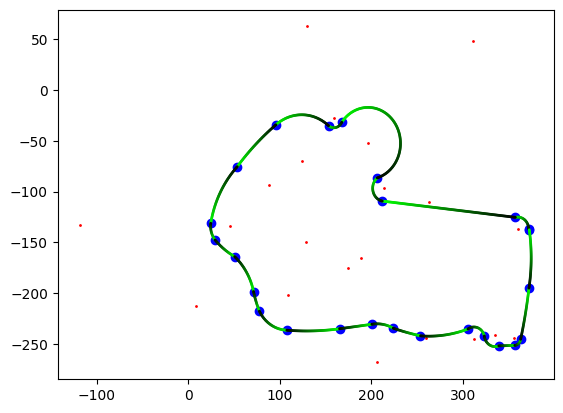

In [36]:
show_data(json_data, interp)

1070


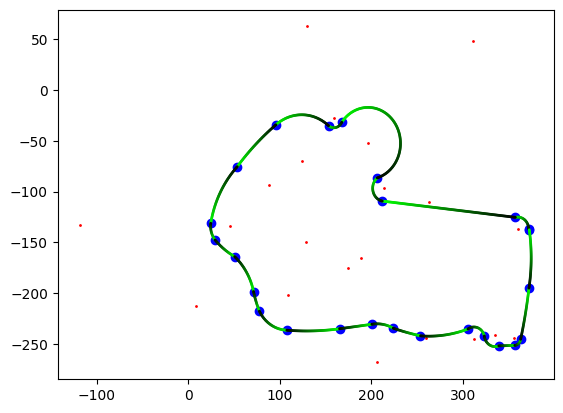

In [9]:
show_data(json_data, interp)